In [11]:
# 'Cell 1: Imports and Configuration'
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import backend.processing_logic as processing_logic
import json
from datetime import datetime

# --- Configuration ---
YOLO_MODEL_PATH = 'backend/resource/yolov8n-seg.pt'
OLLAMA_API_URL = 'http://localhost:11434/api/generate'
DEEPSEEK_MODEL_NAME = 'deepseek-r1:8b'
TEST_IMAGE_PATH = 'backend/resource/bus.jpg'  
METADATA_PATH = 'backend/resource/capture_metadata.json'

print("Configuration set successfully.")
print(f"YOLO Model Path: {YOLO_MODEL_PATH}")
print(f"Ollama API URL: {OLLAMA_API_URL}")
print(f"DeepSeek Model: {DEEPSEEK_MODEL_NAME}")
print(f"Metadata Path: {METADATA_PATH}")

Configuration set successfully.
YOLO Model Path: backend/resource/yolov8n-seg.pt
Ollama API URL: http://localhost:11434/api/generate
DeepSeek Model: deepseek-r1:8b
Metadata Path: backend/resource/capture_metadata.json


In [12]:
# 'Cell 2: Load YOLO Model'
print("Loading YOLO model...")
try:
    yolo_model = YOLO(YOLO_MODEL_PATH)
    print(f"YOLO model '{YOLO_MODEL_PATH}' loaded successfully.")
except Exception as e:
    print(f"Error loading YOLO model: {e}")
    yolo_model = None

Loading YOLO model...
YOLO model 'backend/resource/yolov8n-seg.pt' loaded successfully.


Image captured from webcam at 2025-07-01 12:36:55.
Metadata saved to backend/resource/capture_metadata.json.


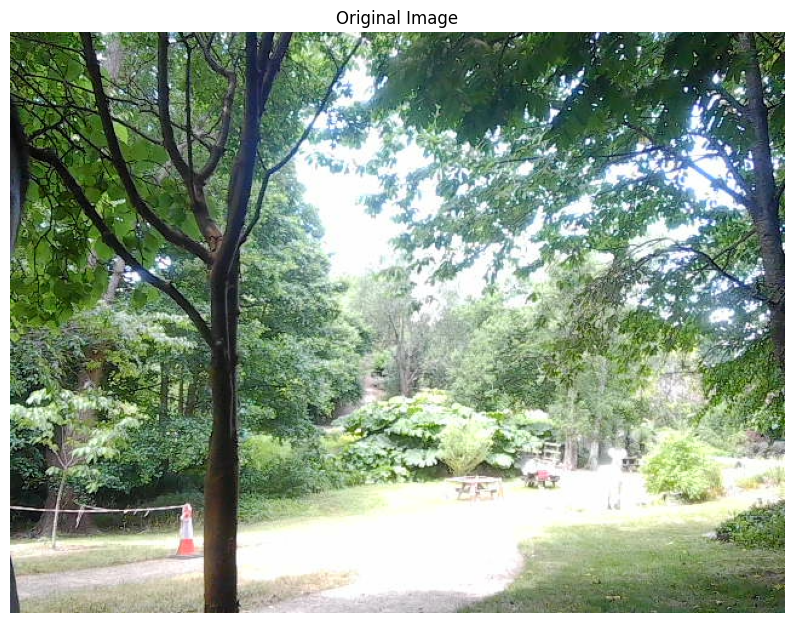

In [19]:
# 'Cell 3: Capture or Load Image'

# choose mode for image input
# mode = input("Select mode ('camera' for webcam, 'image' for file): ").strip().lower()
mode = 'camera'  # for testing purposes, you can change to 'image' to load a file
image_bgr = None
capture_time = None

if mode == 'camera':
    # Initialize webcam
    cap = cv2.VideoCapture(0)  # default camera index is 0
    if not cap.isOpened():
        print('Error: Unable to access the webcam.')
    else:
        try:
            # capture a single frame
            ret, frame = cap.read()
            if ret:
                image_bgr = frame
                capture_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                print(f'Image captured from webcam at {capture_time}.')
                # save the captured image
                os.makedirs('backend/resource', exist_ok=True)
                cv2.imwrite('backend/resource/captured_image.jpg', image_bgr)
                # save metadata
                metadata = {"capture_time": capture_time}
                with open(METADATA_PATH, 'w') as f:
                    json.dump(metadata, f)
                print(f'Metadata saved to {METADATA_PATH}.')
            else:
                print('Error: Failed to capture image from webcam.')
        finally:
            cap.release()  # release the webcam resource
elif mode == 'image':
    # check if the test image exists
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f'Error: Test image not found at \'{TEST_IMAGE_PATH}\'')
        print('Please place a test image in the project root directory.')
    else:
        # read the image from file (RGB format)
        image_bgr = cv2.imread(TEST_IMAGE_PATH)
        print(f'Image \'{TEST_IMAGE_PATH}\' loaded successfully.')
else:
    print('Error: Invalid mode selected. Please choose "camera" or "image".')

# show the loaded image if available
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    plt.show()
else:
    print('No image loaded.')

In [20]:
# 'Cell 4: Process Image and Describe'

print('Starting the image segmentation pipeline...')
print('This may take a moment as it involves YOLO segmentation.')

# check if the model and image are loaded successfully
if 'yolo_model' in locals() and yolo_model is not None and 'image_bgr' in locals() and image_bgr is not None:
    # Call the processing logic to segment and describe the image
    json_detections, annotated_image_bgr = processing_logic.process_image_and_describe(
        image_bgr,
        yolo_model,
        DEEPSEEK_MODEL_NAME,
        OLLAMA_API_URL,
        capture_time=capture_time
    )
    print('Segmentation complete.')
else:
    print('Skipping segmentation due to errors in previous steps (model or image not loaded).')
    json_detections = json.dumps({"message": "Segmentation failed."})
    annotated_image_bgr = image_bgr  # show the original image if segmentation fails

Starting the image segmentation pipeline...
This may take a moment as it involves YOLO segmentation.

0: 480x640 1 person, 112.3ms
Speed: 14.7ms preprocess, 112.3ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)
Segmentation complete.


Image captured at: 2025-07-01 12:36:55


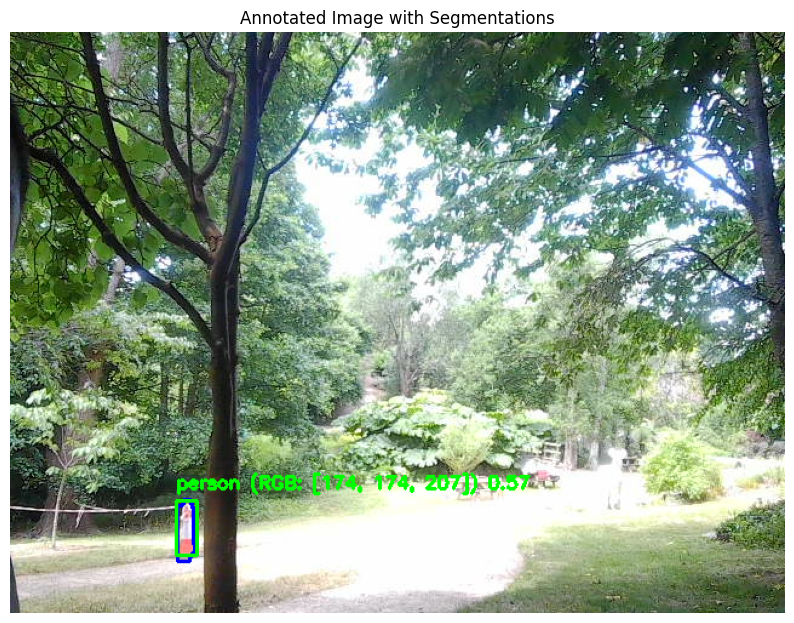

In [22]:
# Cell 5: Display Annotated Image

# show capture time if available
if capture_time:
    print(f"Image captured at: {capture_time}")
else:
    print("No capture time available (image mode).")

# show annotated image 
if annotated_image_bgr is not None:
    annotated_image_rgb = cv2.cvtColor(annotated_image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(annotated_image_rgb)
    plt.title('Annotated Image with Segmentations')
    plt.axis('off')
    plt.show()
else:
    print('No annotated image available.')

In [17]:
# Cell 6: Answer Questions
import sys

# Loop to ask questions about the image
while True:
    question = input("Enter your question about the image (or 'quit' to exit): ").strip()
    if question.lower() == 'quit':
        break
    if not question:
        print("Please enter a valid question.")
        sys.stdout.flush()
        continue
    
    print(f"Question: {question}")
    print("Generating answer, please wait...")
    sys.stdout.flush()
    
    print(f"Question: {question}")
    answer = processing_logic.answer_question_with_deepseek(
        json_detections,
        question,
        OLLAMA_API_URL,
        DEEPSEEK_MODEL_NAME
    )
    print(f"Answer: {answer}")
    sys.stdout.flush()
    print("-------------------------------------------------------------------------------------------------------------------------")


Question: what did you see
Generating answer, please wait...
Question: what did you see
Answer: <think>
Okay, let's look at the user query first - they're asking about an image captured at a specific time based on detection data from a computer vision model.

The image dimensions are 480x640 pixels, and there are three person detections with varying confidence levels (highest is 0.85). The bounding boxes show all these people occupy large portions of the frame vertically but different horizontal positions - one near left edge [21-303] and two on right side [522-639 & 103-300].

Their main question "what did you see" is simple but requires synthesizing all this data. Considering both the bounding boxes and dominant colors (all around neutral grays), it's clear we're looking at multiple people in gray clothing against a presumably light background.

The user might be testing if I can handle general descriptive queries or perhaps they want concise image summaries for some application like

In [1]:
# Cell 7: Display Color Histograms

# Show color histograms for detected objects
if json_detections:
    detections = json.loads(json_detections)
    if detections.get("detections"):
        for i, detection in enumerate(detections["detections"]):
            class_name = detection["class"]
            rgb = detection["dominant_color_rgb"]
            hist_r = detection["color_histogram"]["r"]
            hist_g = detection["color_histogram"]["g"]
            hist_b = detection["color_histogram"]["b"]
            
            # display the histogram
            plt.figure(figsize=(8, 4))
            bins = range(16)
            plt.plot(bins, hist_r, color='red', label='Red')
            plt.plot(bins, hist_g, color='green', label='Green')
            plt.plot(bins, hist_b, color='blue', label='Blue')
            plt.title(f'Color Histogram for {class_name} (RGB: {rgb})')
            plt.xlabel('Bin')
            plt.ylabel('Normalized Frequency')
            plt.legend()
            plt.grid(True)
            plt.show()
    else:
        print("No objects detected, no histograms to display.")
else:
    print("No detection data available.")

NameError: name 'json_detections' is not defined